In [3]:
import os
from os import listdir

import math
import sys
import shutil
from glob import glob
from tqdm import tqdm
from random import shuffle

import cv2
import numpy as np
import torch
from torch import nn
# import albumentations as A

import matplotlib.pyplot as plt

import mlflow

In [ ]:
!pip install albumentations -q

In [2]:
!pip install mlflow -q

### RQ

In [85]:
1. What is the best encoder-decoder for the selected task? Does it have statistically significant difference regarding other trained models?
2. Does the pre-training has statistically significant influence on the metric?

Future work:


SyntaxError: invalid syntax (785563495.py, line 4)

### Preprocessing & EDA (sort of)

Let us see what do we have here.

In [163]:
folders = ['raw_data/santa_rosa/', 'raw_data/ventura/']

In [164]:
inputs = []
targets = []
for folder in folders:
    aggregated_input = []
    for image_path in [folder+f for f in listdir(folder)]:
        image = plt.imread(image_path)
        if 'all' in image_path:  
            targets.append(image)
            print(f'Target image {image_path} shape is {targets[-1].shape}')
        else:
            aggregated_input.append(image[:, :, np.newaxis])
            print(f'Input image {image_path} shape is {aggregated_input[-1].shape}')
    inputs.append(np.concatenate(aggregated_input, axis=2))

Input image raw_data/santa_rosa/GRN.tif shape is (2160, 2148, 1)
Input image raw_data/santa_rosa/RED.tif shape is (2160, 2148, 1)
Input image raw_data/santa_rosa/BLUE.tif shape is (2160, 2148, 1)
Target image raw_data/santa_rosa/all.tif shape is (2160, 2148, 4)
Input image raw_data/ventura/GRN.tif shape is (4418, 4573, 1)
Input image raw_data/ventura/RED.tif shape is (4418, 4573, 1)
Input image raw_data/ventura/BLUE.tif shape is (4418, 4573, 1)
Target image raw_data/ventura/all.tif shape is (4418, 4573, 4)


Everything is consistent, W and H dimensions of input-target pairs are aligned. Since the input channels were separated, we merged them back together.

Provided segmentation masks has 4 channels which seems to be a little more than expected. Let us ensure that they are identical:

In [165]:
[[(targets[i][:, :, 0] == targets[i][:, :, j]).all() for j in range(4)] for i in range(len(targets))] 

[[True, True, True, False], [True, True, True, False]]

First three channels of both images are the same while the last one is empty (hence we can freely discard it and use one of the remaining):

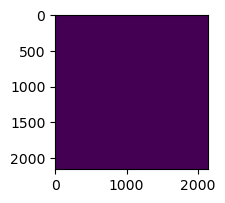

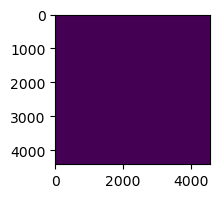

In [166]:
for i in range(len(targets)):
    fig = plt.figure(figsize=(2, 2))
    plt.imshow(targets[i][:, :, 3])
    plt.show()

In [167]:
targets = [target_image[:, :, :3] for target_image in targets]

As we can see, the images are too large to be processed. To handle that, we are going to construct the grid and distribute obtained patches between train/val/test sets.

In [168]:
def img_2_grid(img: np.array, patch_size: int) -> list:
    patches = [
        img[x:x+patch_size, y:y+patch_size] 
        for x in range(0, patch_size*np.floor(img.shape[0]/patch_size).astype('int'), patch_size) 
        for y in range(0, patch_size*np.floor(img.shape[1]/patch_size).astype('int'), patch_size)
    ]
    return patches

In [169]:
def plot_grid(grid,row,col,h=10,w=10):
    fig, ax = plt.subplots(nrows=row, ncols=col)
    [axi.set_axis_off() for axi in ax.ravel()]

    fig.set_figheight(h)
    fig.set_figwidth(w)
    c = 0
    for row in ax:
        for col in row:
            col.imshow(np.flip(grid[c],axis=-1))
            c+=1
    plt.show()

In [170]:
PATCH_SIZE = 224

In [171]:
data_i, data_t = img_2_grid(inputs[1], PATCH_SIZE), img_2_grid(targets[0], PATCH_SIZE)

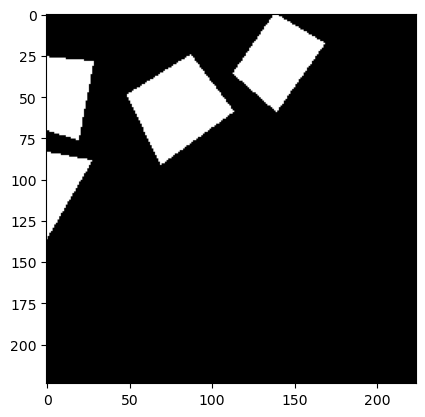

In [172]:
plt.imshow(data_t[8])

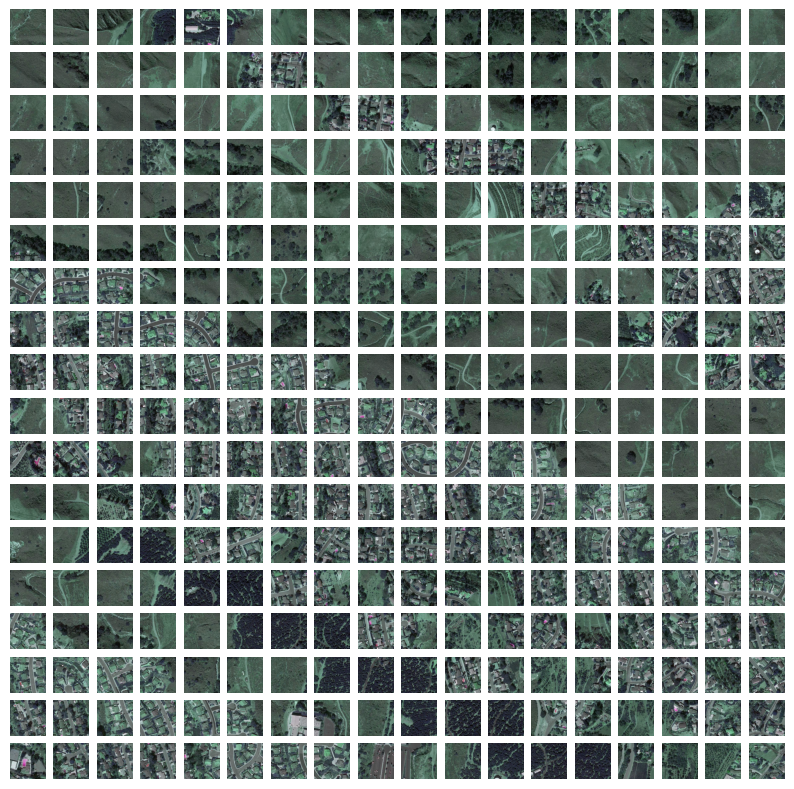

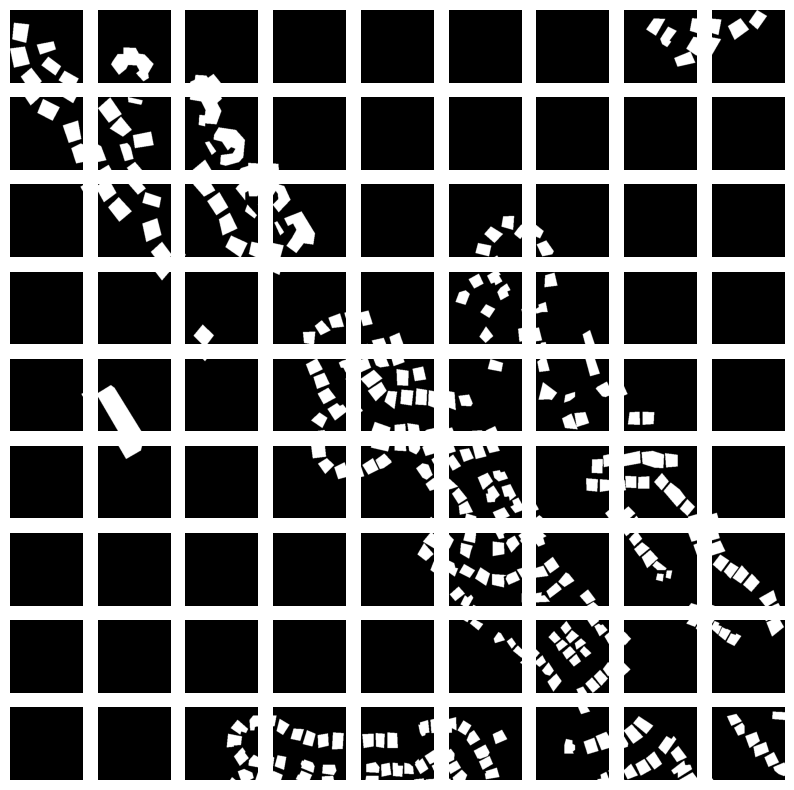

In [173]:
plot_grid(data_i, 18, 18)
plot_grid(data_t, 9, 9)

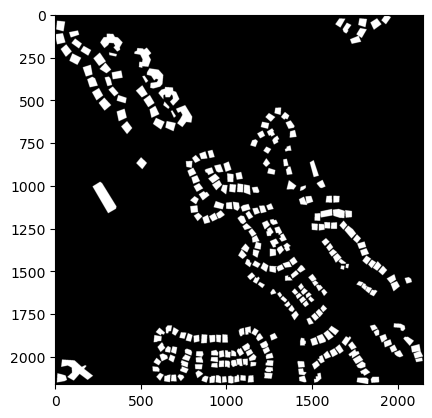

In [174]:
plt.imshow(targets[0])

In [175]:
inputs_s = []
targets_s = []
for input_image, target_image in zip(inputs, targets):
    inputs_s += img_2_grid(input_image, PATCH_SIZE)
    targets_s += img_2_grid(target_image, PATCH_SIZE)

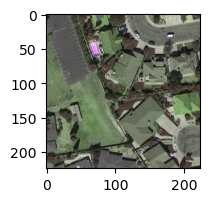

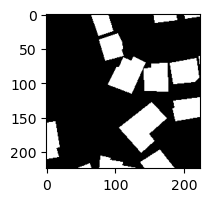

In [176]:
i = 460

fig = plt.figure(figsize=(2, 2))
plt.imshow(inputs_s[i])
plt.show()

fig = plt.figure(figsize=(2, 2))
plt.imshow(targets_s[i])
plt.show()

Why 224? Just because it is a standard input size for most of the image encoders (by the way, I know that it can be done as part of a trasformation pipeline).  

As far as I can see, there is no critical relations between different patches => no data leakage => no specific requrements for train/val/test split. 

In [177]:
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 1 - train_ratio - val_ratio

In [178]:
from sklearn.model_selection import train_test_split

In [179]:
train_imgs, val_imgs, train_targets, val_targets = train_test_split(inputs_s, targets_s, train_size=0.7)
val_imgs, test_imgs, val_targets, test_targets = train_test_split(val_imgs, val_targets, train_size=0.5)

print(f'Train sample size {len(train_imgs)}; validation sample size {len(val_imgs)}; test sample size {len(test_imgs)}')

Train sample size 322; validation sample size 69; test sample size 70


In [214]:
folders = ['processed_data/train', 'processed_data/val', 'processed_data/test']
from PIL import Image

for sample_input, sample_target, folder in zip([train_imgs, val_imgs, test_imgs],
                                               [train_targets, val_targets, test_targets],
                                               ['processed_data/train', 'processed_data/val', 'processed_data/test']
                                              ):
    for i, (image, target) in tqdm(enumerate(zip(sample_input, sample_target))):
#        plt.imsave(f'./{folder}/images/{i}.png', image)
#        plt.imsave(f'{folder}/masks/{i}.png', target)
        Image.fromarray(image, 'RGB').save(f'./{folder}/images/{i}.png')        
        Image.fromarray(target, 'RGB').save(f'./{folder}/masks/{i}.png')


322it [00:05, 54.18it/s]
69it [00:01, 54.01it/s]
70it [00:01, 53.15it/s]


### Models

Since the provided data is limited, it is natural to use some pre-trained architectures to achieve better results. Among all of the packages for segmentation, the pytorch-segmentation framework cought my eye due to the wide range of availabe architectures.

In [4]:
!pip install segmentation-models-pytorch -q

For our task we will borrow augmentations once applied during the encoder pre-training:

In [5]:
from segmentation_models_pytorch.encoders import get_preprocessing_fn

preprocess_input = get_preprocessing_fn('resnet34', pretrained='imagenet')

Due to the limited amount of data, it will be better to also augment it by flips, crops, etc.

In [6]:
from torchvision.transforms import v2

transform_input = v2.Compose([
#    v2.RandomCrop(128),
#    v2.RandomHorizontalFlip(),
#    v2.RandomRotation(degrees=(0, 180)),
    get_preprocessing_fn('resnet34', pretrained='imagenet'),
#color_shift = transforms.ColorJitter(.1,.1,.1,.1)
#blurriness = transforms.GaussianBlur(3, sigma=(0.1, 2.0))
    v2.ToTensor()
])

transform_mask = v2.Compose([
    v2.ToTensor()
])

/opt/saturncloud/envs/saturn/lib/python3.10/site-packages/torchvision/transforms/v2/_deprecated.py:43: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


In [28]:
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

In [29]:
%load_ext autoreload
%autoreload 2

from utils import SegDataset

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [30]:
train_dataset = SegDataset(inputs_path='processed_data/train/images/',
                              targets_path='processed_data/train/masks/',
                              transform_input=transform_input,
                              transform_mask=transform_mask)

val_dataset = SegDataset(inputs_path='processed_data/val/images/',
                              targets_path='processed_data/val/masks/',
                              transform_input=transform_input,
                              transform_mask=transform_mask)

test_dataset = SegDataset(inputs_path='processed_data/test/images/',
                              targets_path='processed_data/test/masks/',
                              transform_input=transform_input,
                              transform_mask=transform_mask)

train_dataloader = DataLoader(dataset=train_dataset,
                                      batch_size=4,
                                      shuffle=True)

val_dataloader = DataLoader(dataset=val_dataset,
                                      batch_size=4,
                                      shuffle=True)

test_dataloader = DataLoader(dataset=test_dataset,
                                      batch_size=4,
                                      shuffle=True)

In [10]:
image, mask, i_id, t_id = next(iter(train_dataloader))

In [11]:
from utils import visualize

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


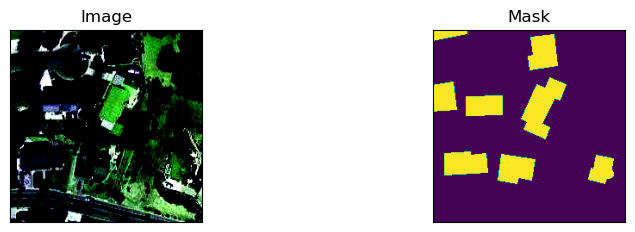

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


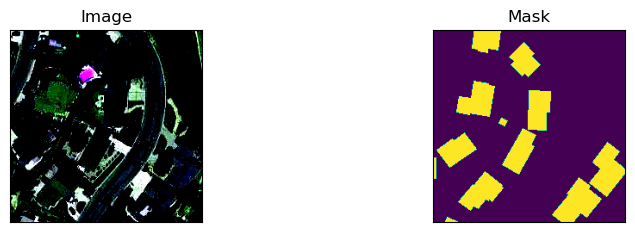

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


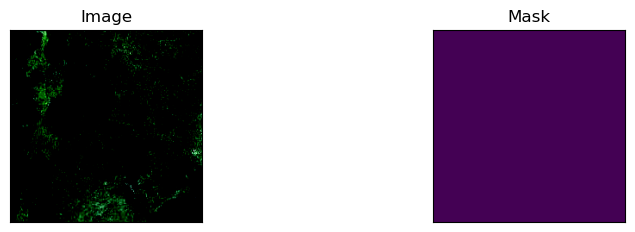

In [12]:
for i in range(3):
    image, mask, i_id, t_id = next(iter(train_dataloader))
    visualize(image=image[0].permute(1, 2, 0), mask=mask[0][np.newaxis, 0, :, :].permute(1, 2, 0))

### Training

In [41]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = 'cpu'
print(device)
print(torch.cuda.get_device_name())
print(torch.cuda.device_count())

cuda
Tesla T4
1


In [42]:
from utils import FocalLoss
from utils import mIoULoss
from utils import seg_acc as acc

In [66]:
focal_criterion = FocalLoss(gamma=1.75).to(device)
jaccard_criterion = mIoULoss(n_classes=2).to(device)

criterion = focal_criterion

In [67]:
import segmentation_models_pytorch as smp

model = smp.Unet(
    encoder_name="resnet34",    
    encoder_weights="imagenet",     
    in_channels=3,                  
    classes=2,                      
).to(device)

In [68]:
### just a test, do not take it seriously

x, y, i_id, t_id = next(iter(train_dataloader))

print(x.shape, y[:, 0, :].shape)

out = model(x.cuda())
print(out.shape)

criterion(out, y[:, 0, :].cuda())

torch.Size([4, 3, 224, 224]) torch.Size([4, 224, 224])
torch.Size([4, 2, 224, 224])


tensor(0.9101, device='cuda:0', grad_fn=<MeanBackward0>)

In [69]:
N_EPOCHS = 100
    
min_loss = torch.tensor(float('inf'))

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.5)

In [70]:
os.environ['MLFLOW_TRACKING_USERNAME'] = 'Eighonet'
os.environ['MLFLOW_TRACKING_PASSWORD'] = '507106c5c84dd39e349e6dbe8bf63f4aa36c2a0b'

In [71]:
mlflow.set_tracking_uri('https://dagshub.com/Eighonet/aerial-segmentation.mlflow')
    
os.makedirs('./saved_models', exist_ok=True)

with mlflow.start_run(run_name='unet_MAIN_focal_1.75'):

    plot_losses = []
    scheduler_counter = 0

    for epoch in tqdm(range(N_EPOCHS)):
        # ======= TRAIN PART ==========
        model.train()

        jac_train, foc_train = [], []
        acc_train = []
        loss_train = []
        
        for batch_i, (x, y, _, _) in enumerate(train_dataloader):
            optimizer.zero_grad()
            
            y = y[:, 0, :]
            pred_mask = model(x.to(device))
            
#            print(x.shape, pred_mask.shape, y.shape)
            
            loss = criterion(pred_mask, y.to(device))
            jac = jaccard_criterion(pred_mask, y.to(device))
            foc = focal_criterion(pred_mask, y.to(device))
            
            loss.backward()
            optimizer.step()
            
            loss_train.append(loss.cpu().detach().numpy())
            acc_train.append(acc(y, pred_mask).numpy())
            jac_train.append(jac.cpu().detach().numpy())
            foc_train.append(foc.cpu().detach().numpy())
        
        mlflow.log_metrics(
            {
                'train/loss':np.mean(loss_train),
                'train/acc':np.mean(acc_train),
                'train/jaccard':np.mean(jac_train),
                'train/focal':np.mean(foc_train)
            }, step=epoch)
        
        scheduler_counter += 1
        
        # ======= VALIDATION PART ==========
        model.eval()
        jac_val, foc_val = [], []
        acc_val = []
        loss_val = []
        for batch_i, (x, y, _, _) in enumerate(val_dataloader):
            
            y = y[:, 0, :]
            
            with torch.no_grad():
                pred_mask = model(x.to(device))
            
            jac = jaccard_criterion(pred_mask, y.to(device))
            foc = focal_criterion(pred_mask, y.to(device))
            loss = criterion(pred_mask, y.to(device))
            
            loss_val.append(loss.cpu().detach().numpy())
            jac_val.append(jac.cpu().detach().numpy())
            foc_val.append(foc.cpu().detach().numpy())
            acc_val.append(acc(y,pred_mask).numpy())


        mlflow.log_metrics(
            {
                'val/loss':np.mean(loss_val),
                'val/acc':np.mean(acc_val),
                'val/jaccard':np.mean(jac_val),
                'val/focal':np.mean(foc_val)
            }, step=epoch)

        compare_loss = np.mean(loss_val)
        is_best = compare_loss < min_loss
        if is_best == True:
            scheduler_counter = 0
        min_loss = min(compare_loss, min_loss)
        
        mlflow.log_metrics({'val/min_loss':min_loss}, step=epoch)
    
        torch.save(model.state_dict(), './saved_models/unet_jaccard.pt')
        
        if scheduler_counter > 5:
            lr_scheduler.step()
            print(f"lowering learning rate to {optimizer.param_groups[0]['lr']}")
            scheduler_counter = 0
        mlflow.log_metrics({'lr':optimizer.param_groups[0]['lr']}, step=epoch)

 21%|██        | 21/100 [02:49<10:39,  8.09s/it]

lowering learning rate to 5e-05


 27%|██▋       | 27/100 [03:38<09:48,  8.06s/it]

lowering learning rate to 2.5e-05


 29%|██▉       | 29/100 [03:57<09:42,  8.21s/it]


KeyboardInterrupt: 

### Result

As for me, it looks well enough.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 224, 224]) (224, 224)


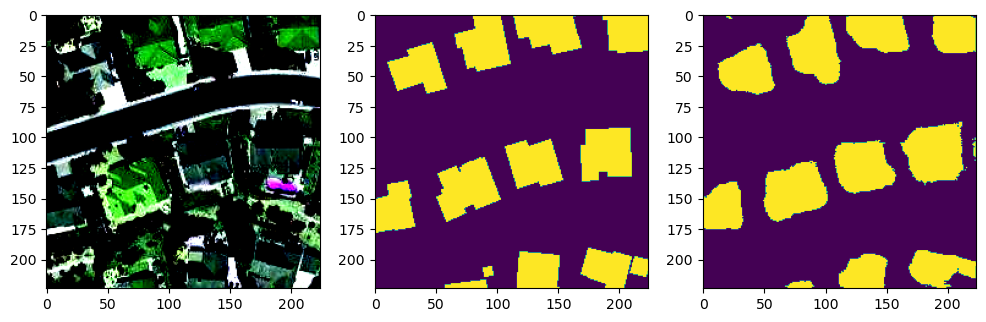

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 224, 224]) (224, 224)


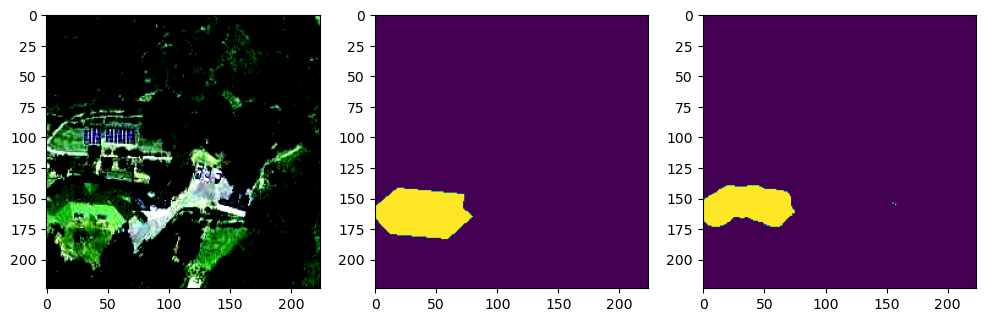

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 224, 224]) (224, 224)


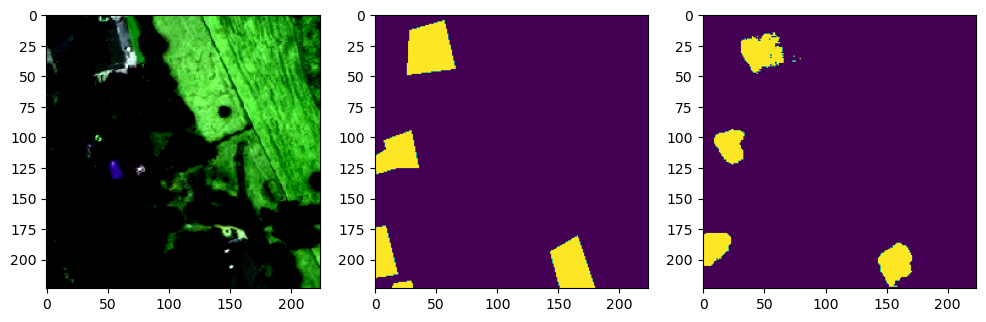

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 224, 224]) (224, 224)


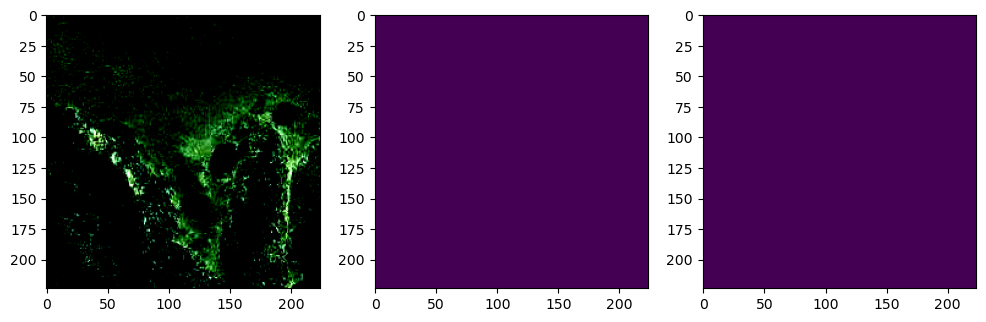

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 224, 224]) (224, 224)


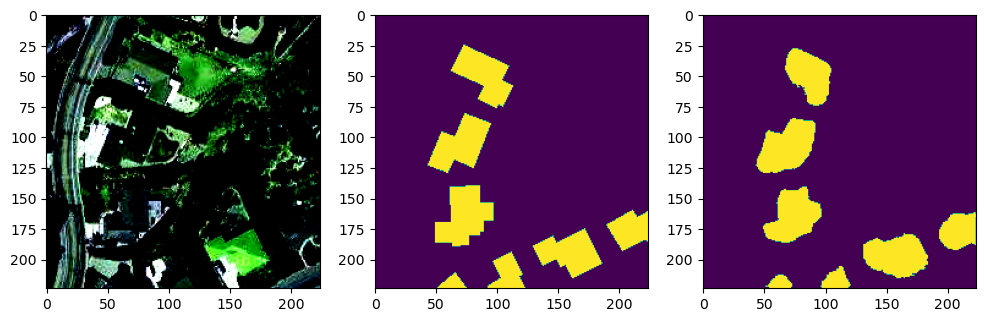

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 224, 224]) (224, 224)


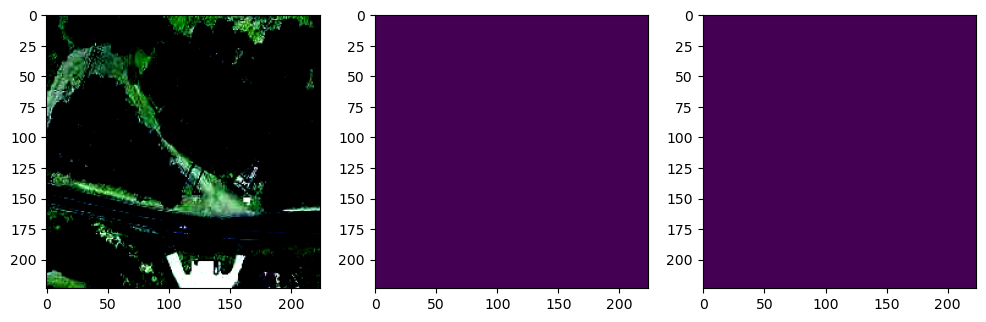

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 224, 224]) (224, 224)


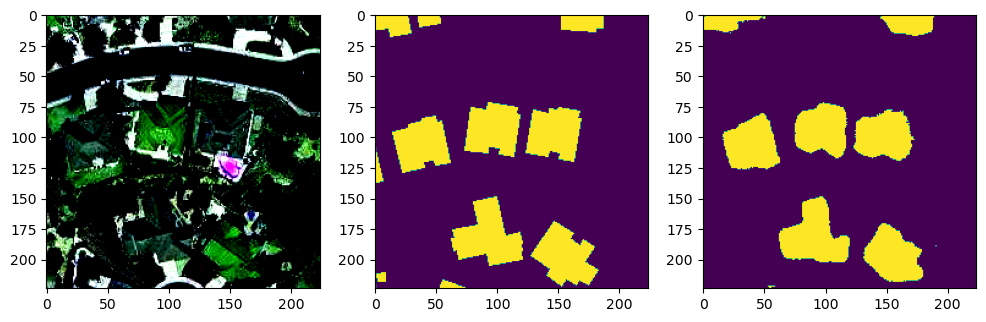

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 224, 224]) (224, 224)


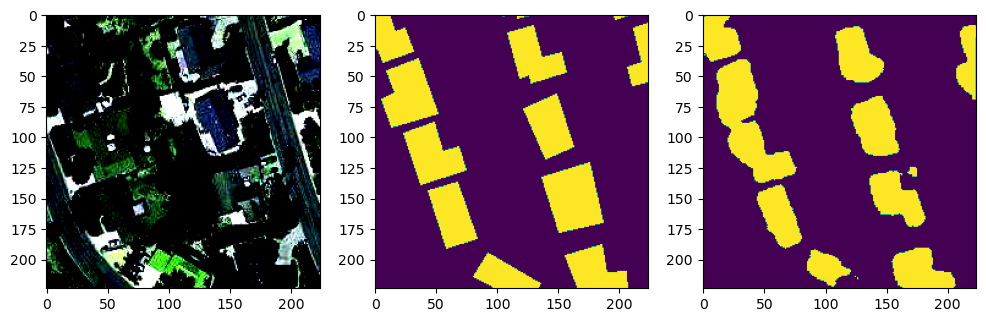

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 224, 224]) (224, 224)


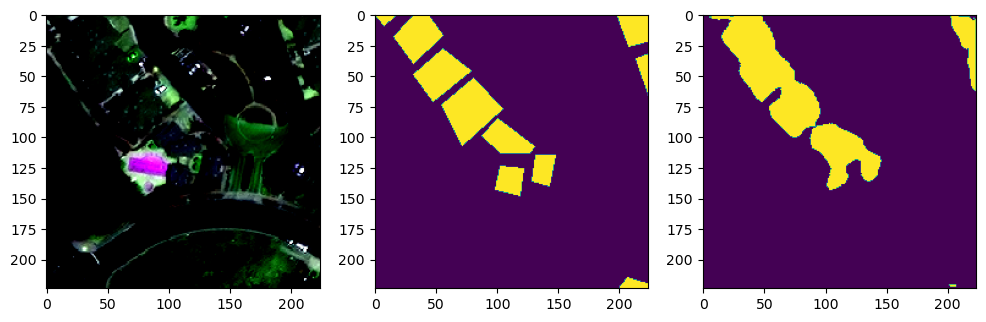

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 224, 224]) (224, 224)


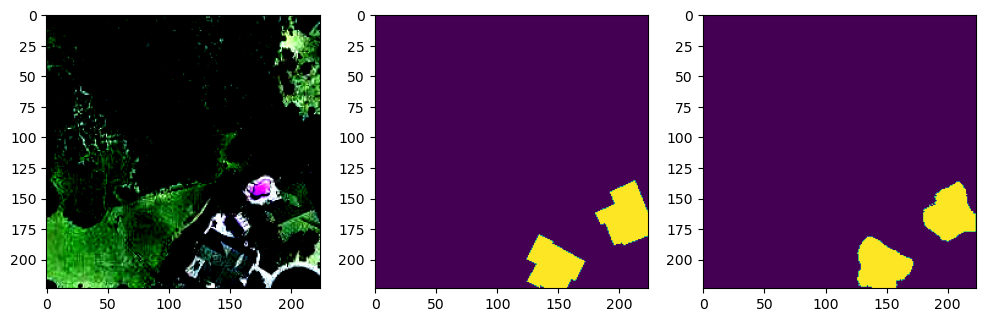

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 224, 224]) (224, 224)


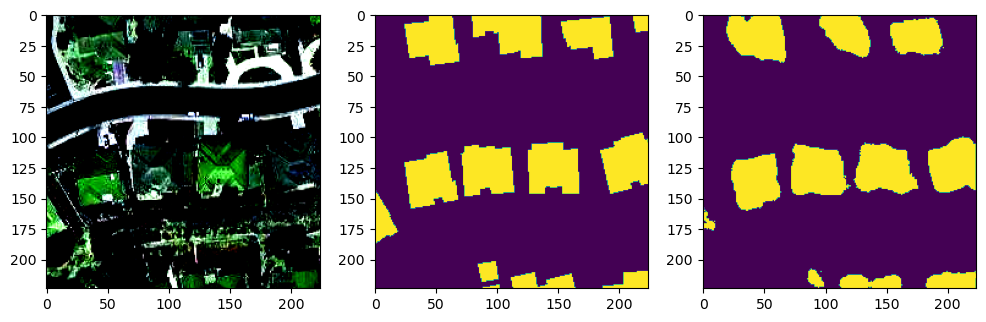

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 224, 224]) (224, 224)


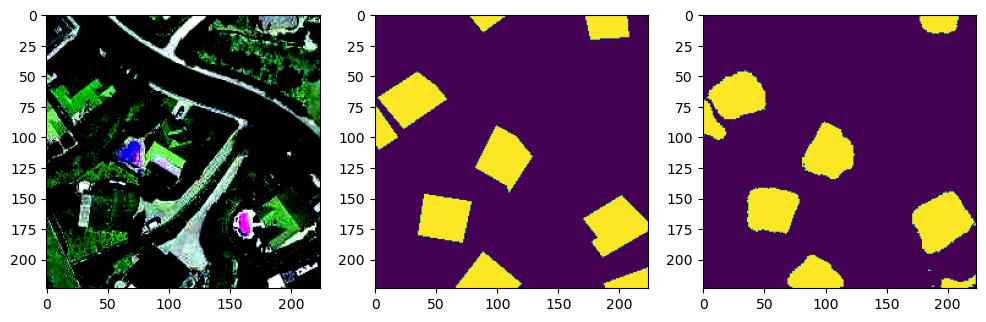

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 224, 224]) (224, 224)


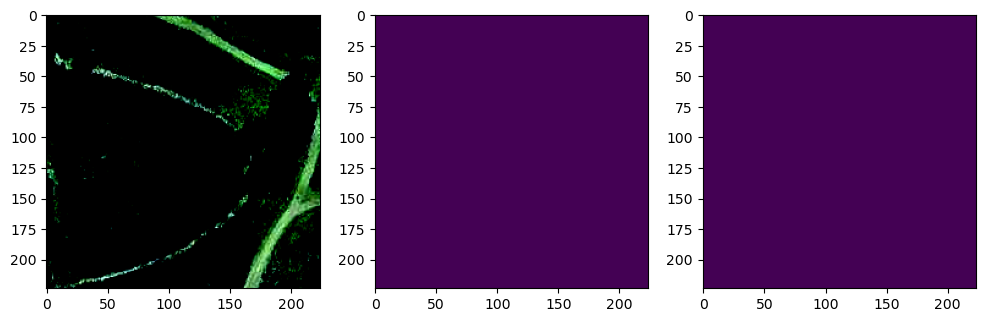

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 224, 224]) (224, 224)


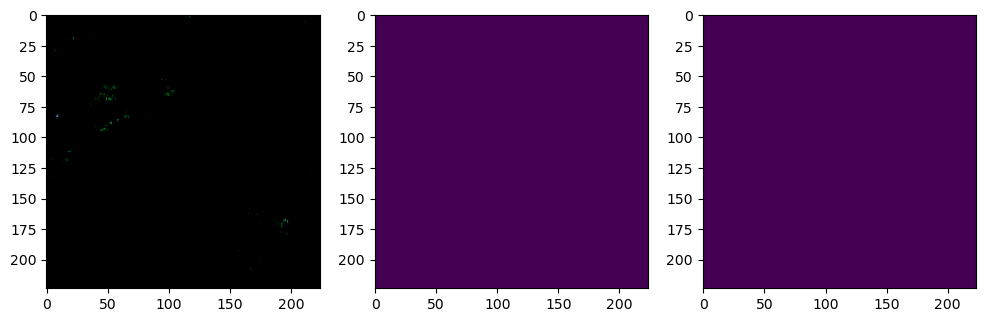

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 224, 224]) (224, 224)


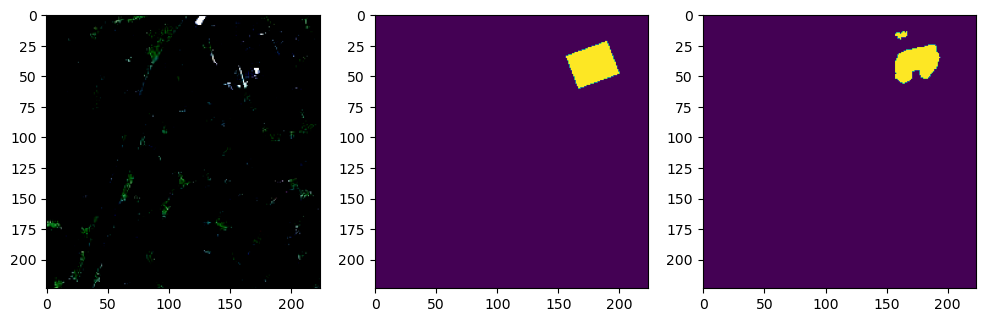

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 224, 224]) (224, 224)


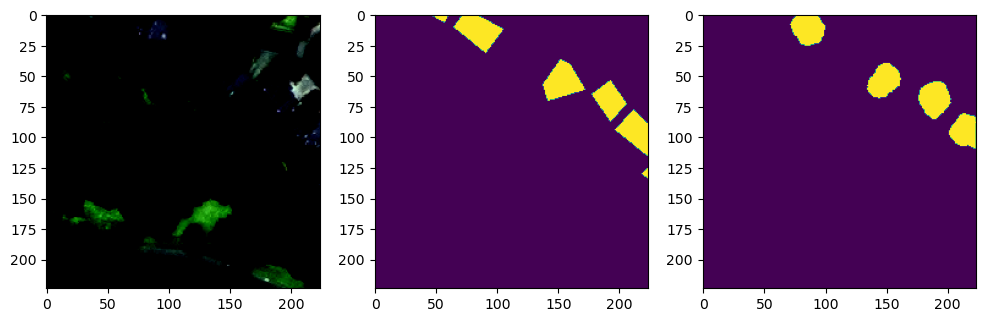

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 224, 224]) (224, 224)


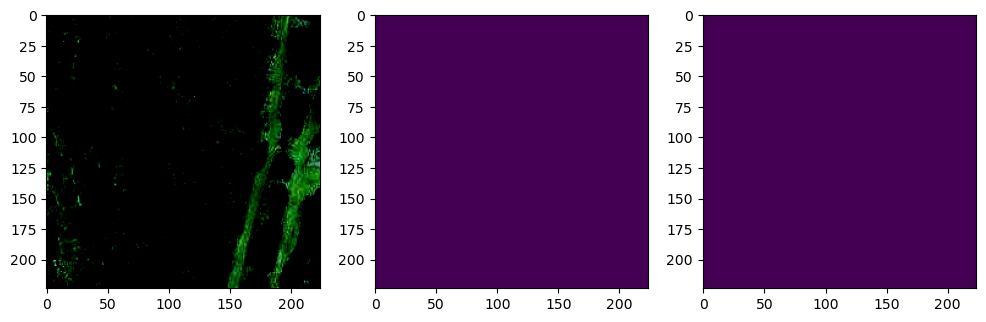

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 224, 224]) (224, 224)


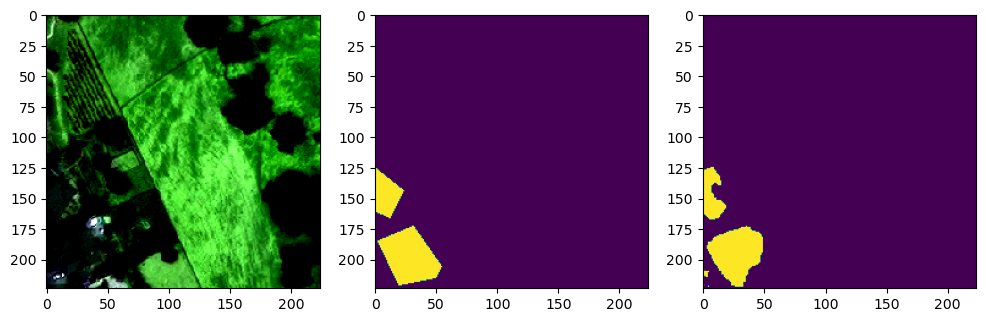

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 224, 224]) (224, 224)


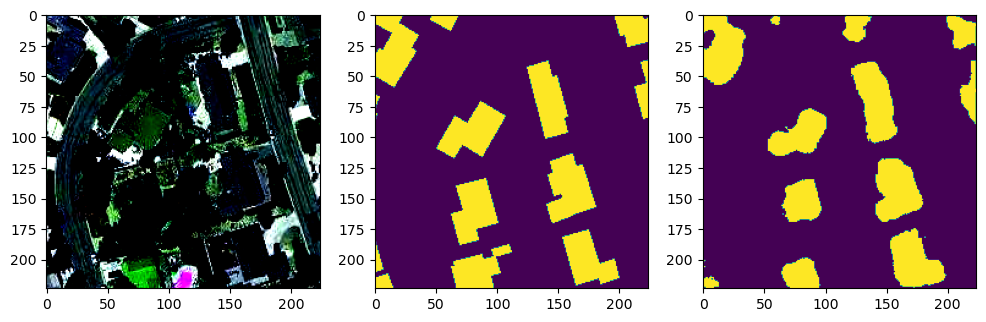

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 224, 224]) (224, 224)


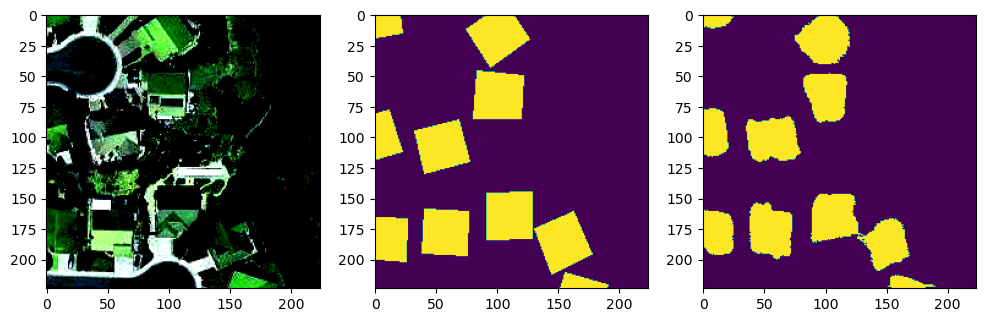

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 224, 224]) (224, 224)


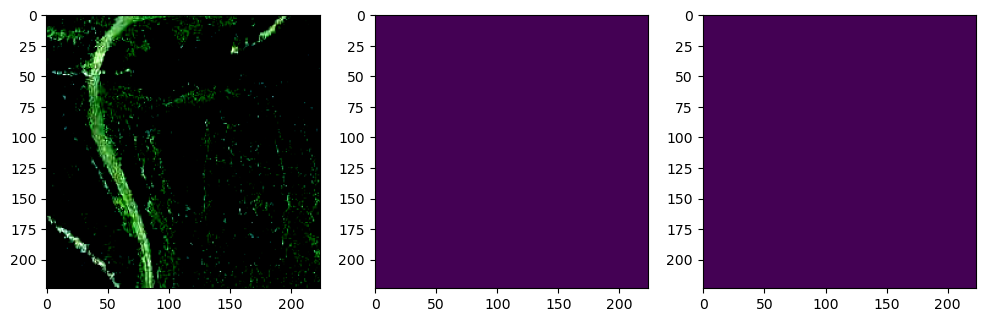

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 224, 224]) (224, 224)


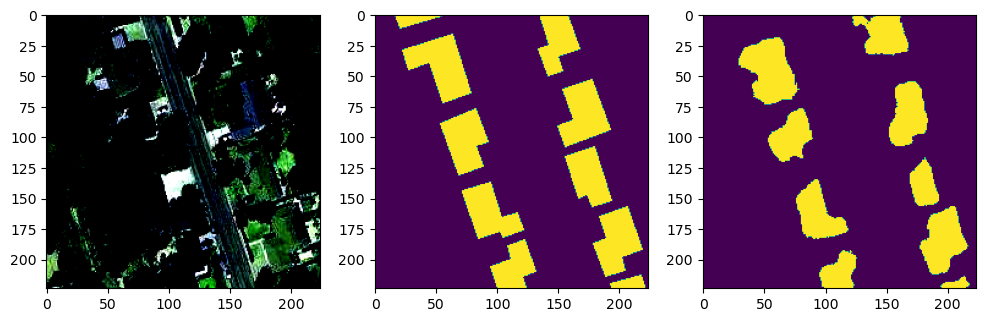

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 224, 224]) (224, 224)


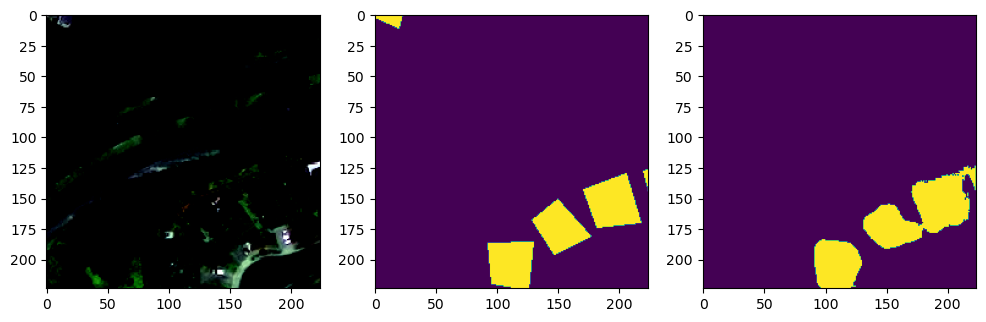

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 224, 224]) (224, 224)


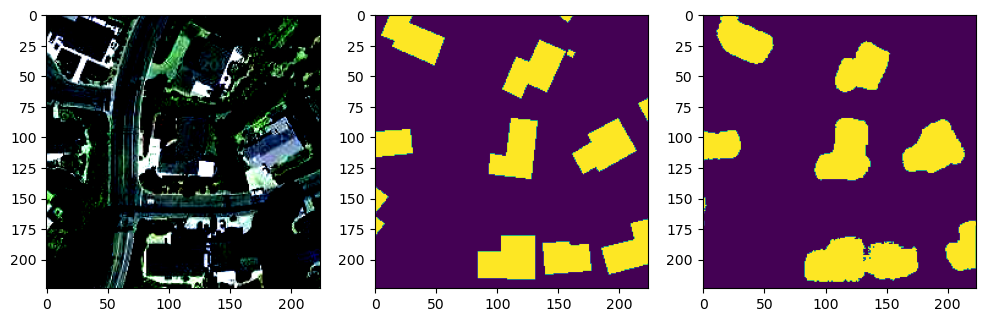

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 224, 224]) (224, 224)


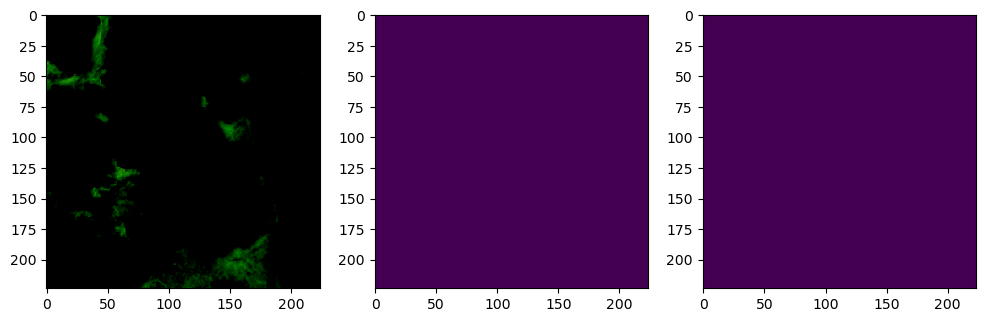

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 224, 224]) (224, 224)


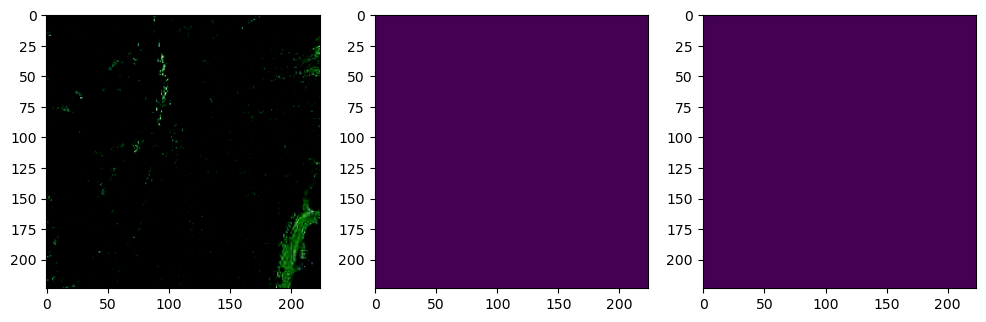

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 224, 224]) (224, 224)


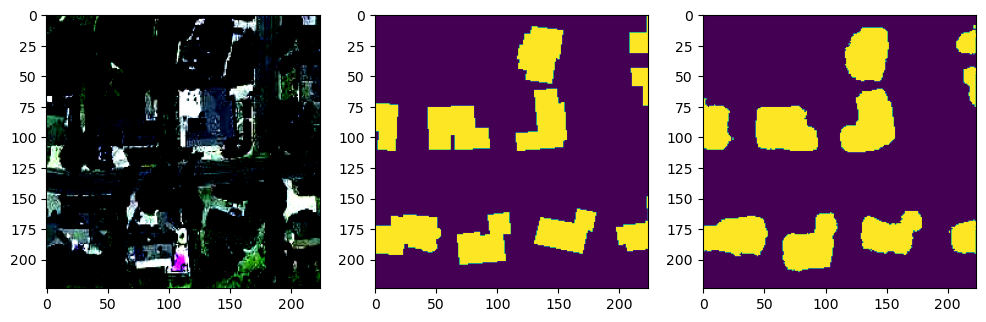

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 224, 224]) (224, 224)


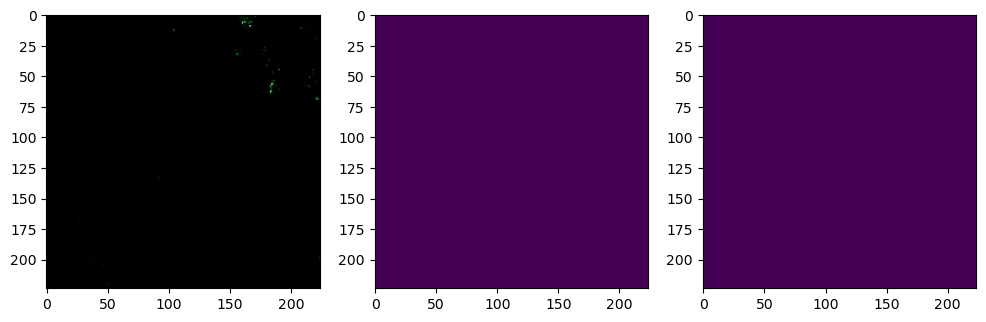

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 224, 224]) (224, 224)


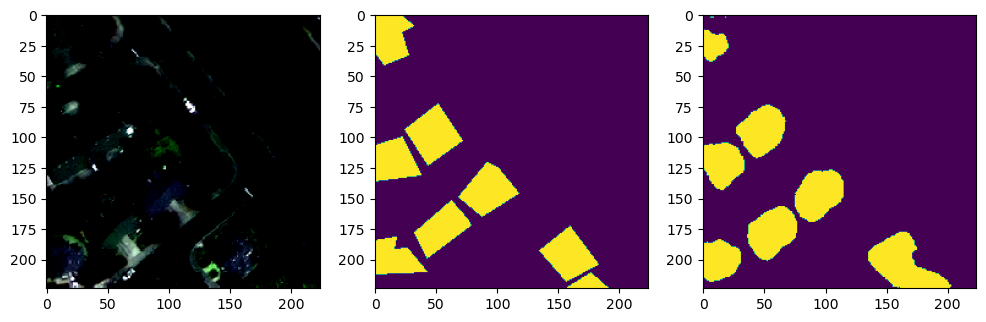

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 224, 224]) (224, 224)


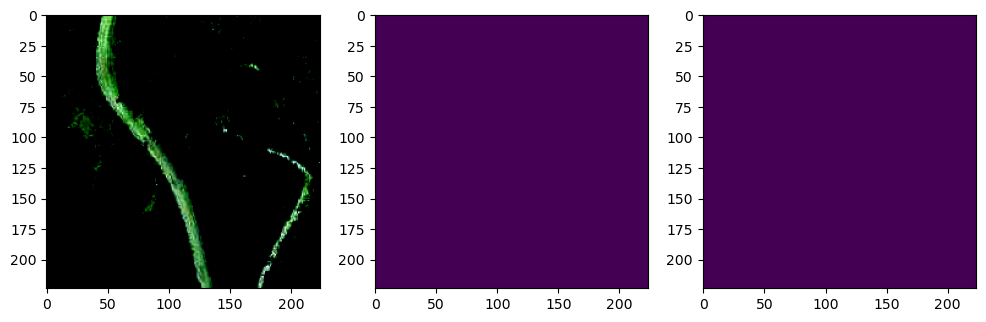

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 224, 224]) (224, 224)


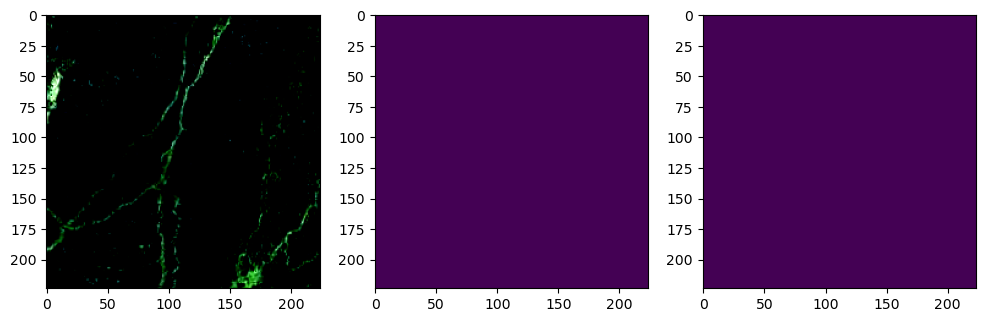

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 224, 224]) (224, 224)


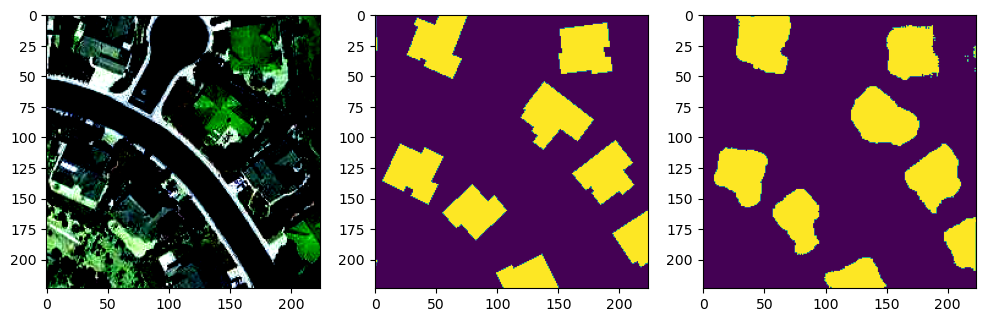

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 224, 224]) (224, 224)


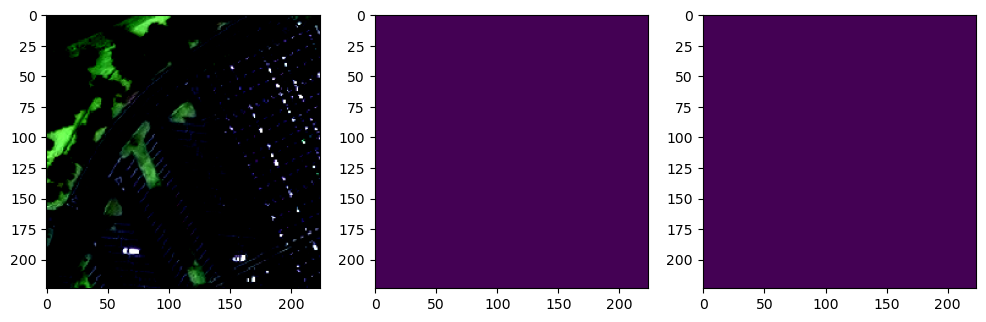

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 224, 224]) (224, 224)


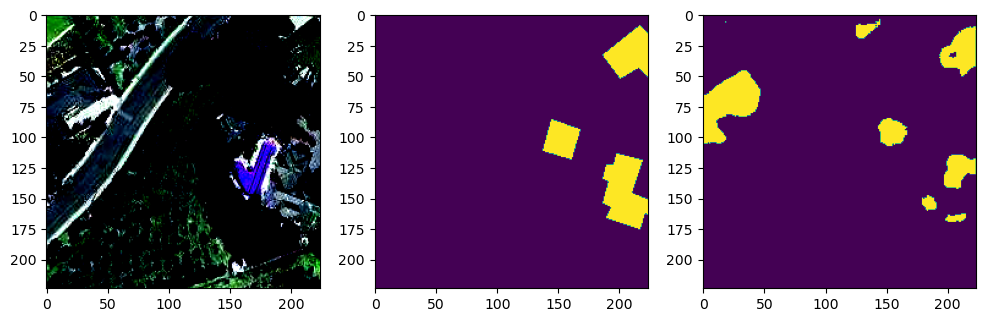

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 224, 224]) (224, 224)


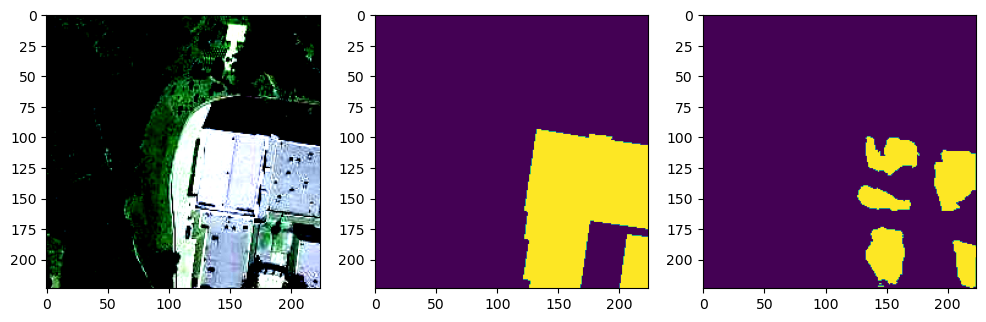

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 224, 224]) (224, 224)


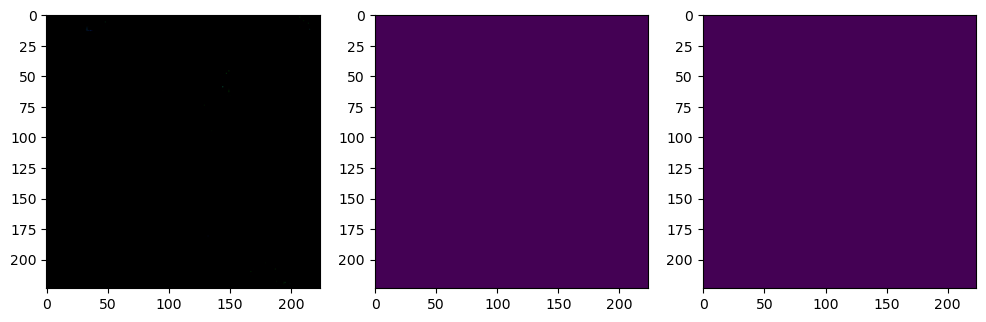

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 224, 224]) (224, 224)


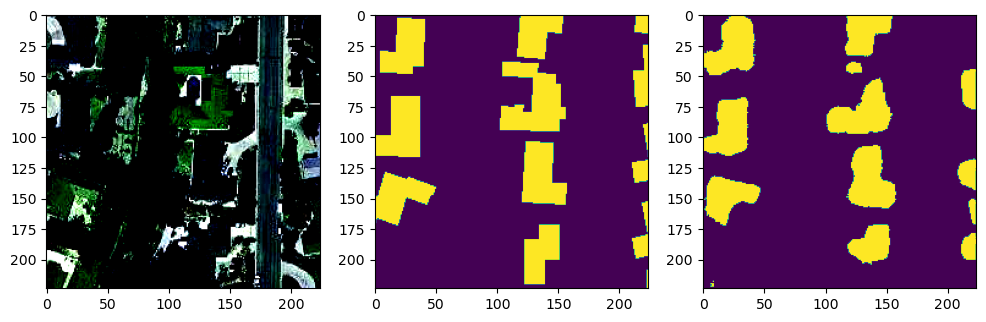

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 224, 224]) (224, 224)


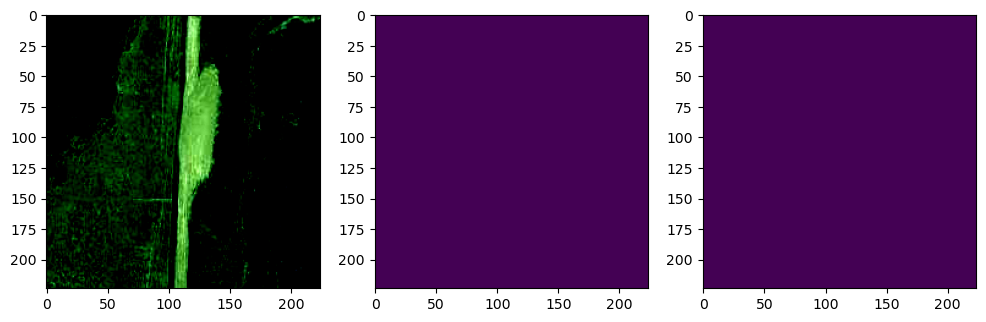

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 224, 224]) (224, 224)


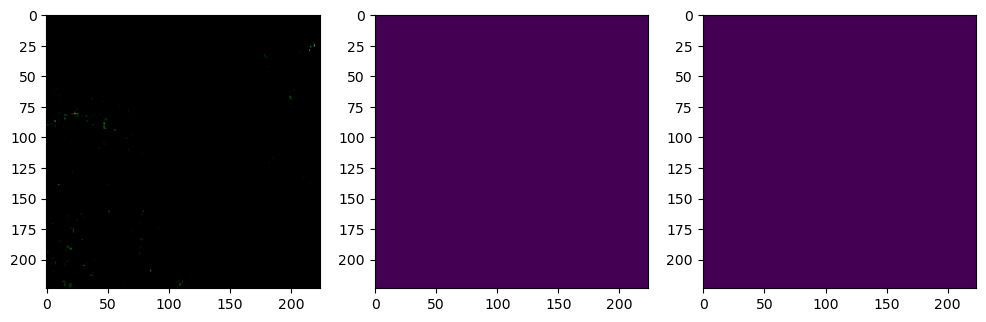

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 224, 224]) (224, 224)


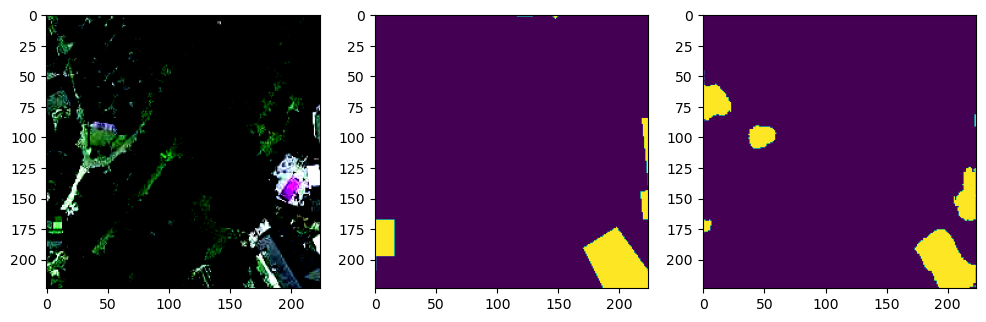

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 224, 224]) (224, 224)


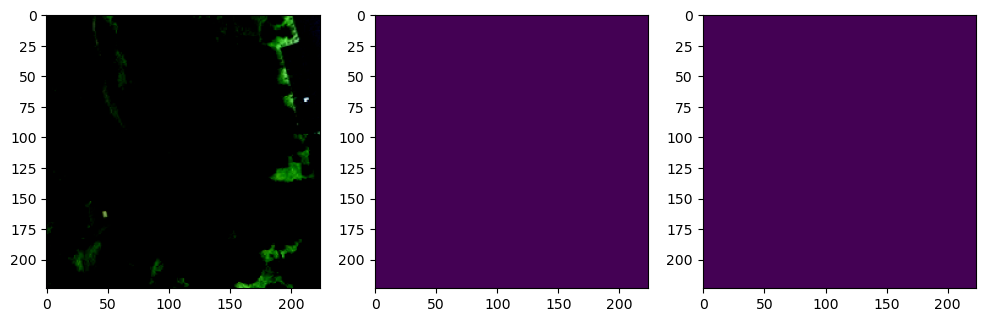

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 224, 224]) (224, 224)


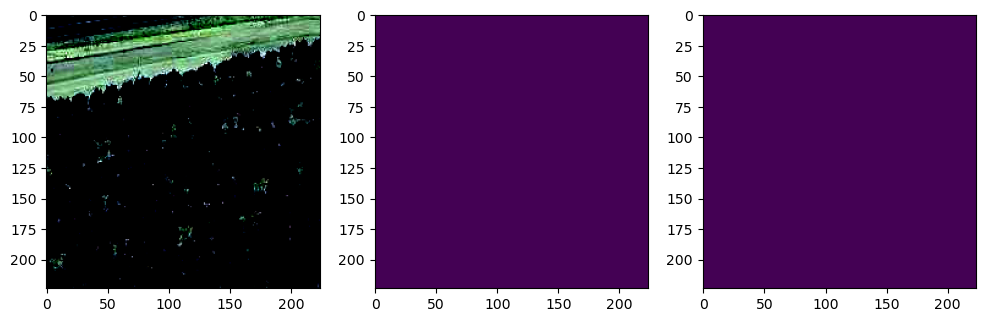

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 224, 224]) (224, 224)


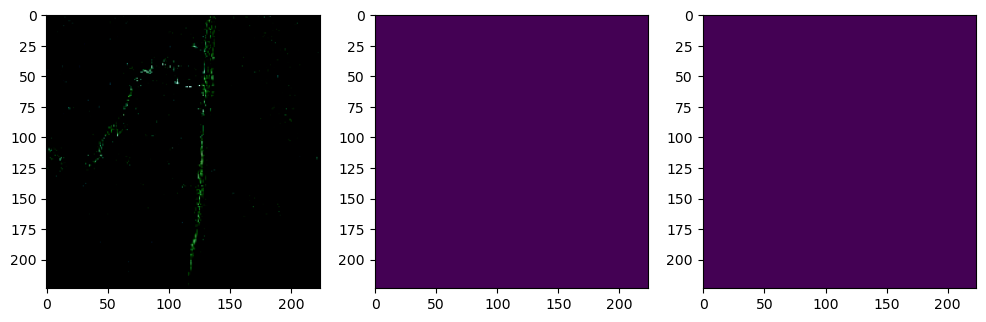

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 224, 224]) (224, 224)


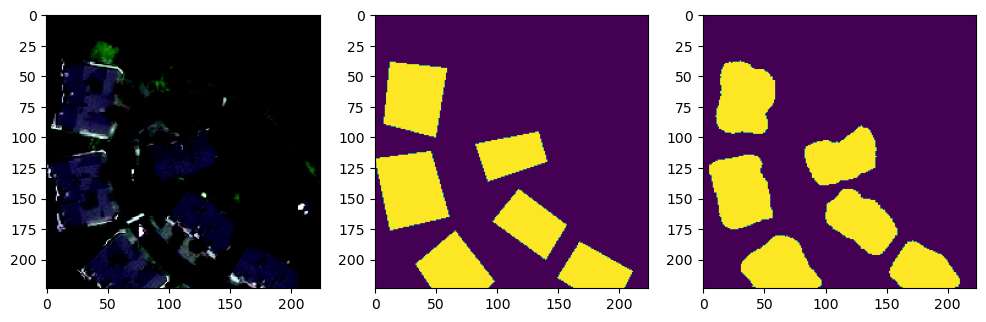

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 224, 224]) (224, 224)


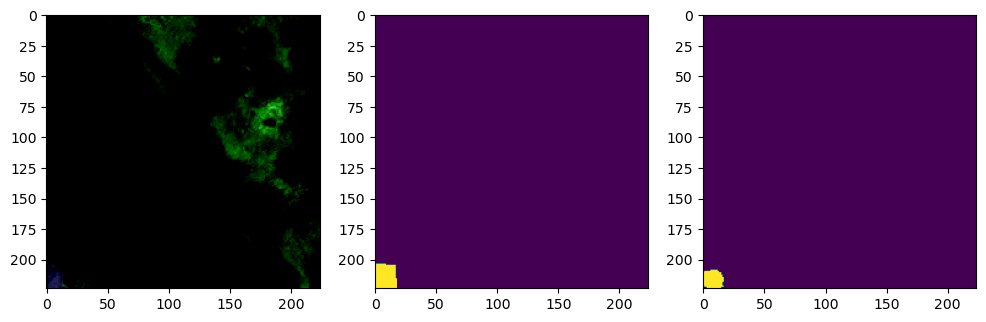

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 224, 224]) (224, 224)


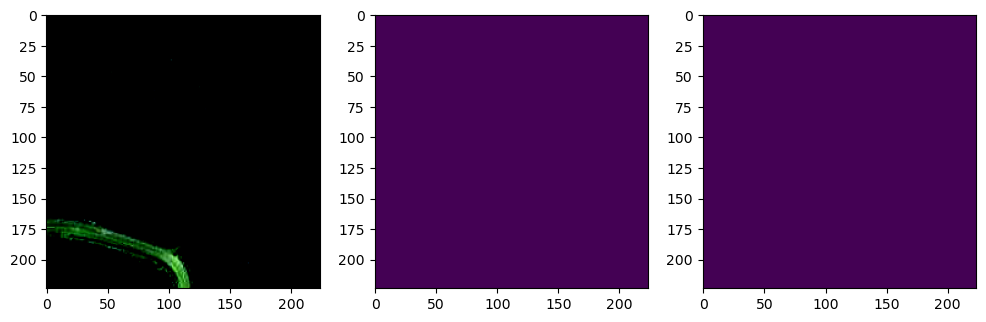

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 224, 224]) (224, 224)


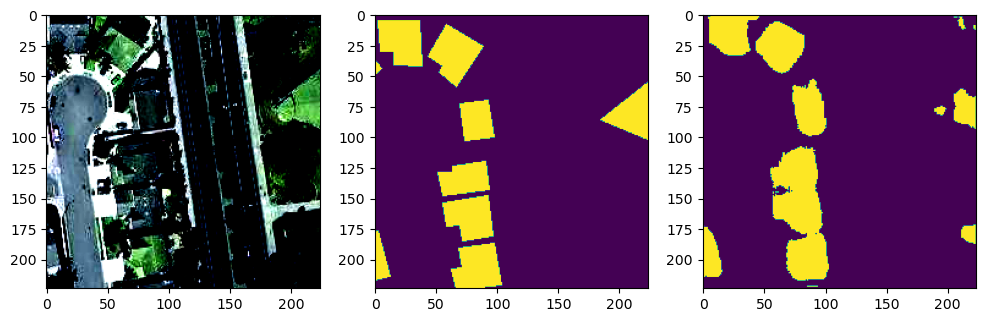

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 224, 224]) (224, 224)


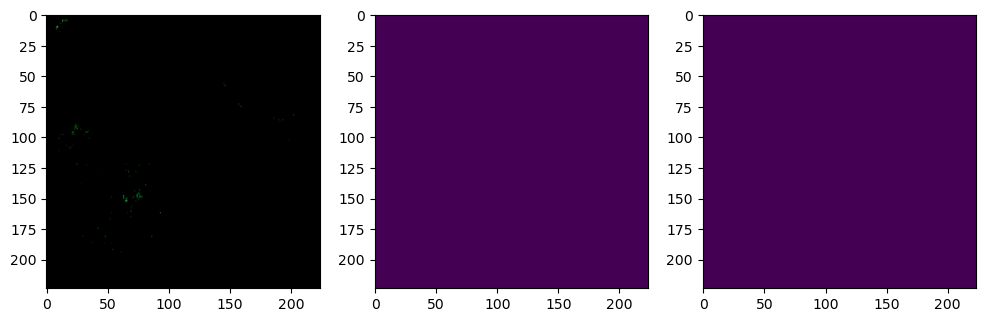

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 224, 224]) (224, 224)


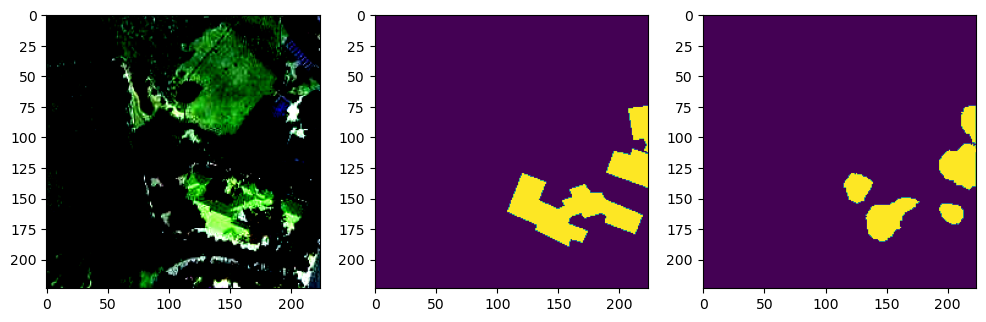

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 224, 224]) (224, 224)


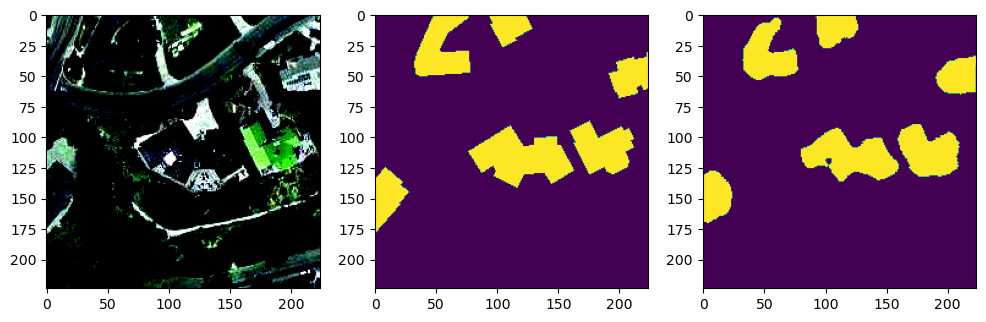

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 224, 224]) (224, 224)


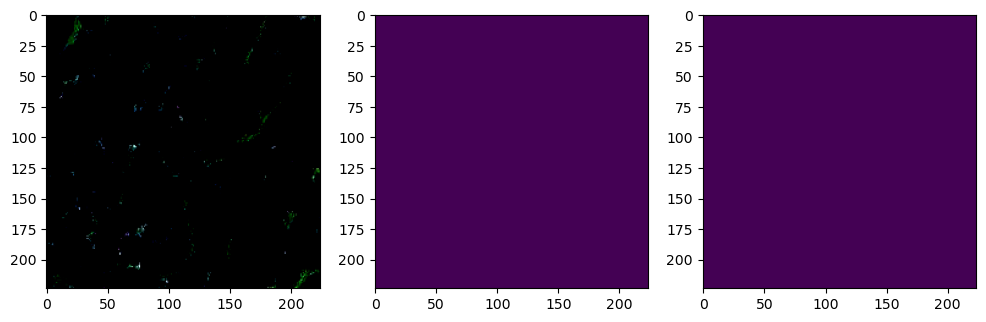

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 224, 224]) (224, 224)


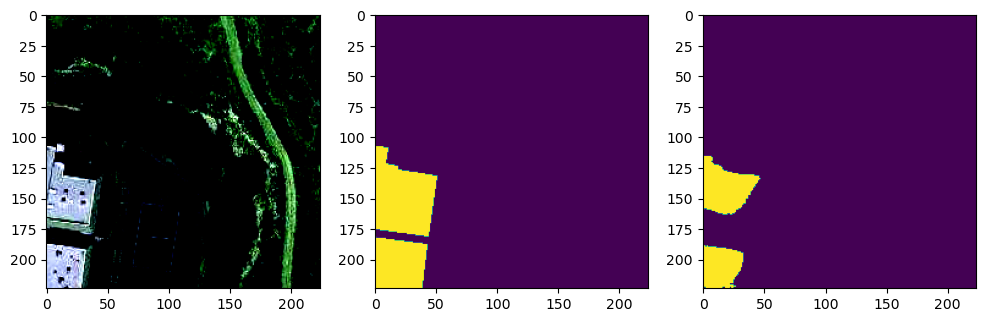

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 224, 224]) (224, 224)


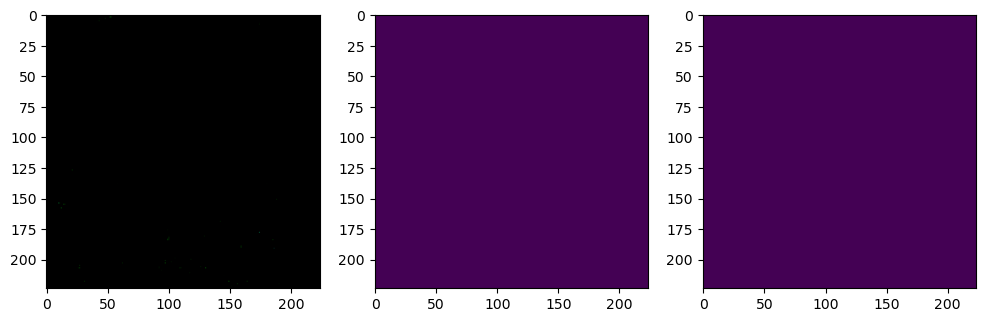

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 224, 224]) (224, 224)


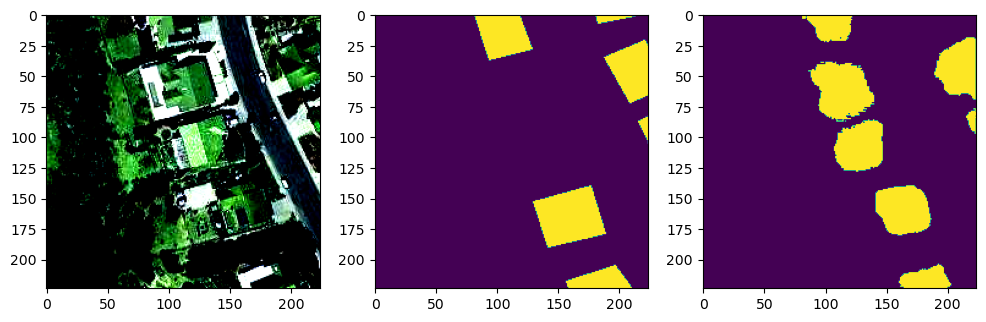

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 224, 224]) (224, 224)


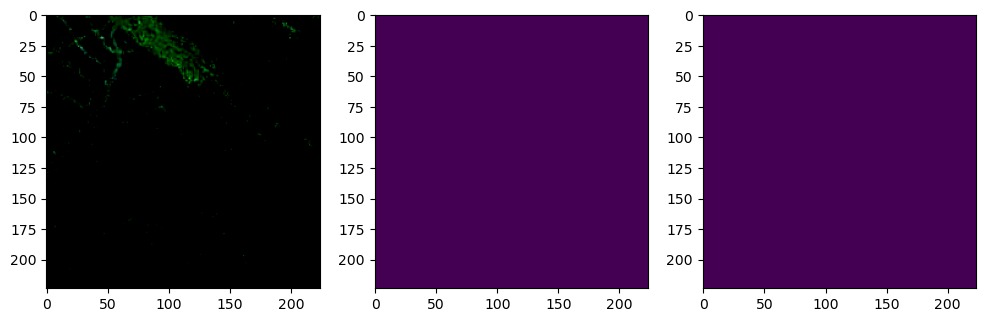

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 224, 224]) (224, 224)


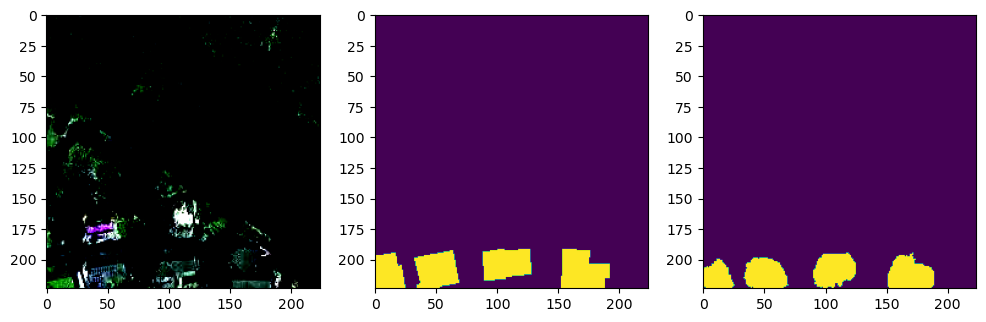

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 224, 224]) (224, 224)


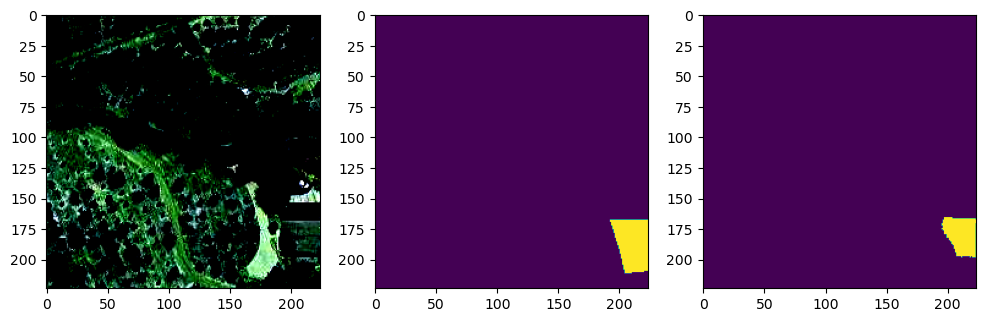

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 224, 224]) (224, 224)


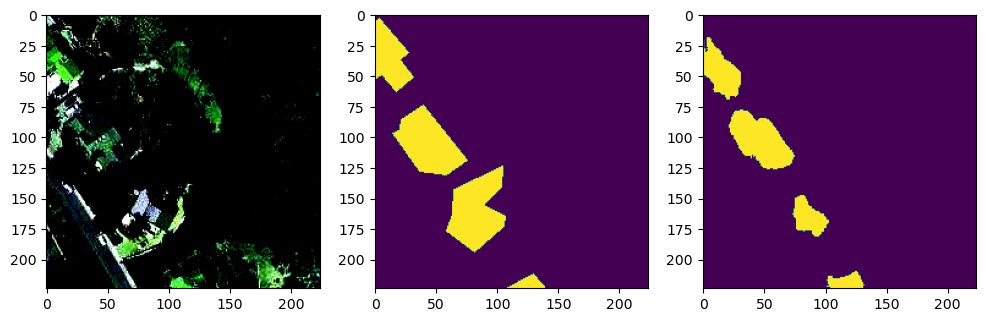

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 224, 224]) (224, 224)


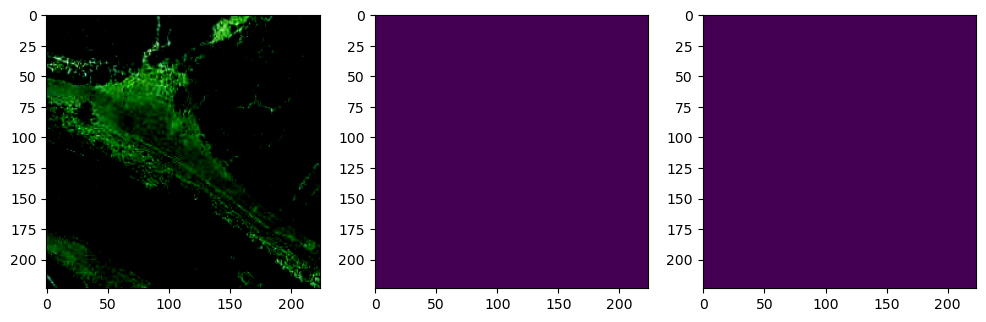

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 224, 224]) (224, 224)


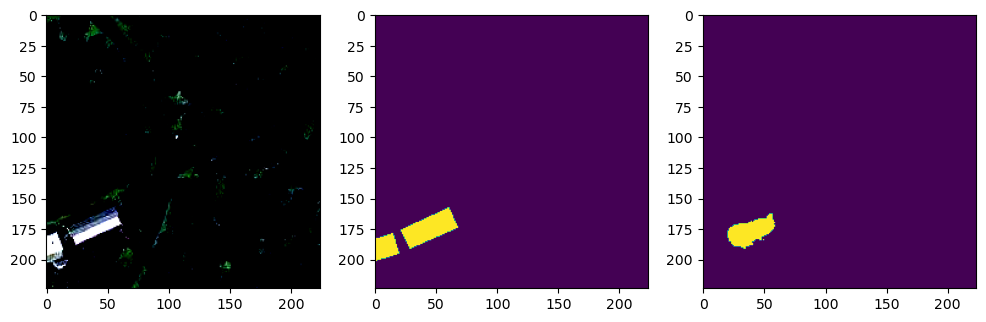

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 224, 224]) (224, 224)


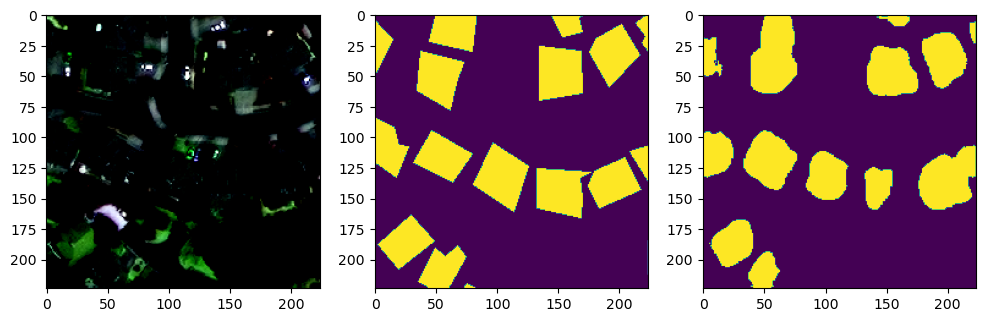

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 224, 224]) (224, 224)


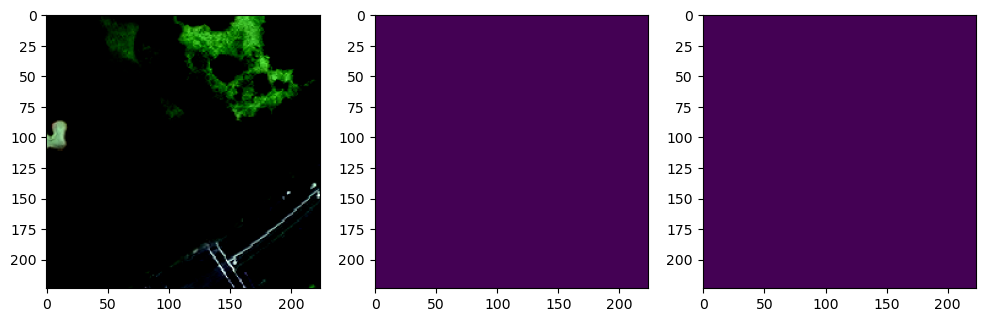

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 224, 224]) (224, 224)


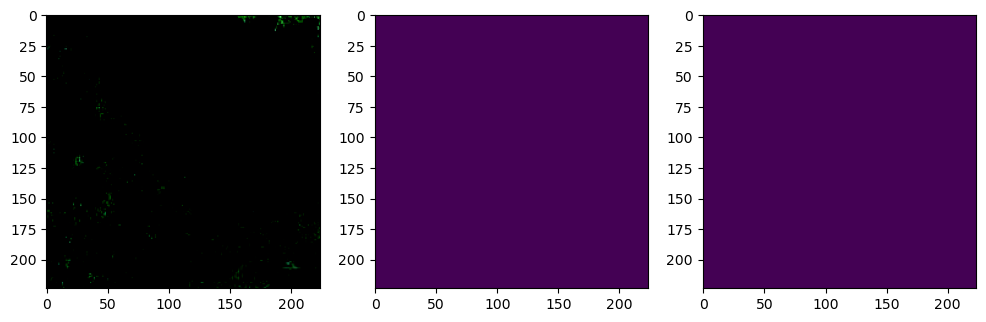

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 224, 224]) (224, 224)


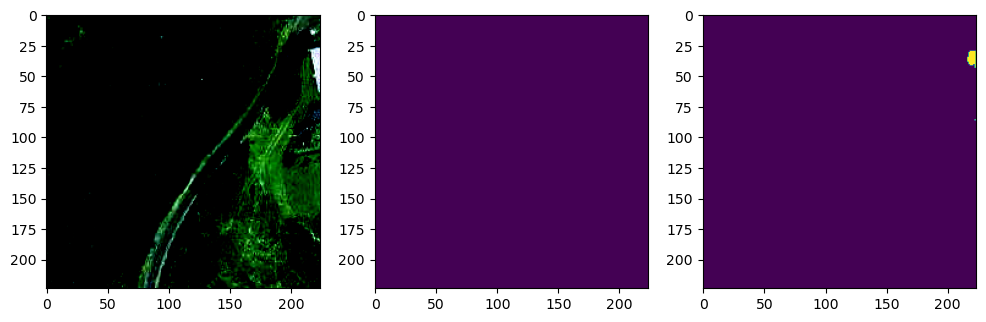

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 224, 224]) (224, 224)


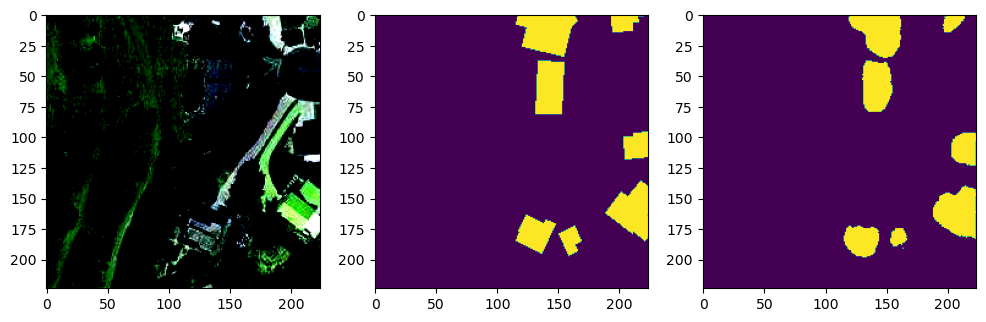

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 224, 224]) (224, 224)


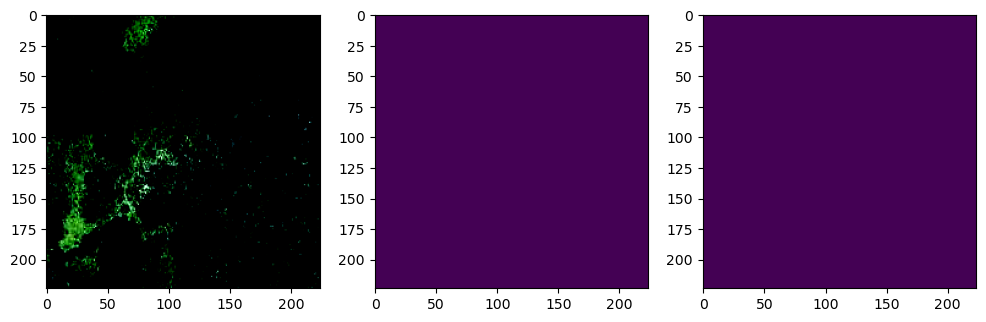

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 224, 224]) (224, 224)


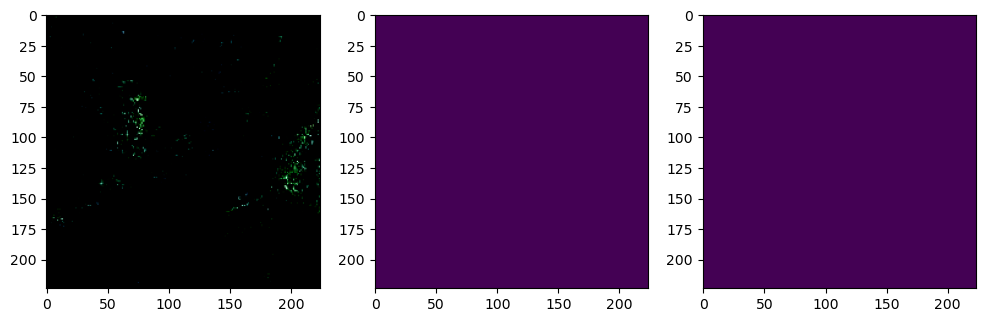

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 224, 224]) (224, 224)


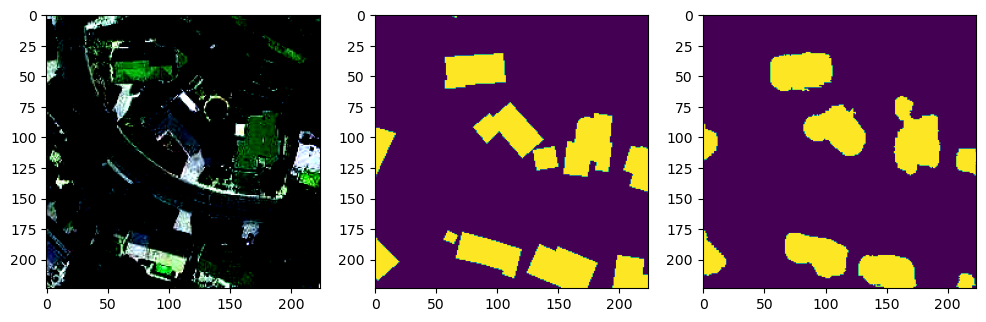

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 224, 224]) (224, 224)


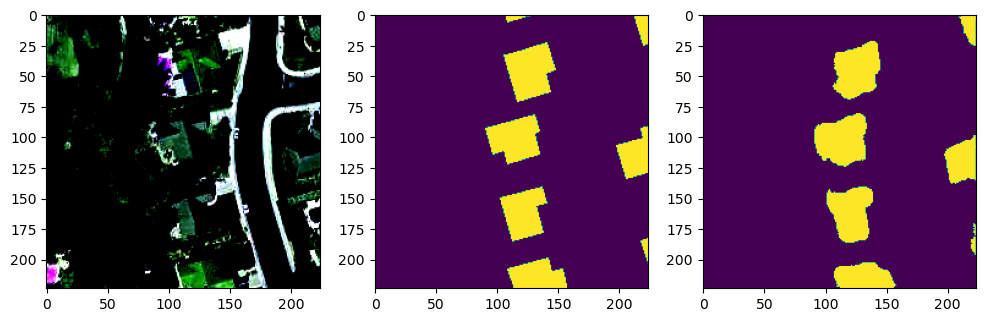

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 224, 224]) (224, 224)


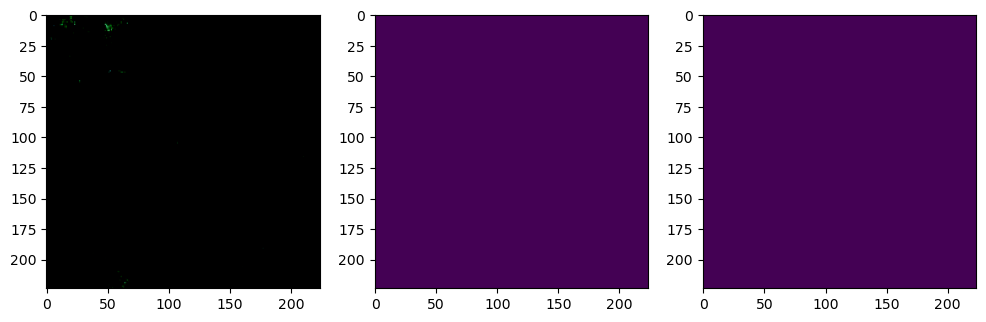

In [78]:
model.eval()

for batch_i, (x, y, _, _) in enumerate(test_dataloader):
    for j in range(len(x)):
        result = model(x.to(device)[j:j+1])
        im = np.moveaxis(x.to(device)[j].cpu().detach().numpy(), 0, -1).copy()*255
        im = im.astype(int)
        
        plt.figure(figsize=(12,12))

        plt.subplot(1,3,1)
        im = np.moveaxis(x.to(device)[j].cpu().detach().numpy(), 0, -1).copy()*255
        im = im.astype(int)
        plt.imshow(im)
        
#        print(gt_mask.shape, mask.shape)
        
        gt_mask = y[j]
        plt.subplot(1,3,2)
        plt.imshow(gt_mask.permute(1, 2, 0).numpy())

        mask = torch.argmax(result, axis=1).cpu().detach().numpy()[0]
        plt.subplot(1,3,3)
        plt.imshow(mask[np.newaxis, :].transpose(1, 2, 0))
        plt.show()

In [ ]:
for batch_i, (x, y, _, _) in enumerate(val_dataloader):            
    y = y[:, 0, :]

    with torch.no_grad():
        pred_mask = model(x.to(device))

In [ ]:
for i in range(3):
    image, mask, i_id, t_id = next(iter(train_dataloader))
    visualize(image=image[0].permute(1, 2, 0), mask=mask[0][np.newaxis, 0, :, :].permute(1, 2, 0))